In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2 
import utils 

%matplotlib inline 

# Clustering 
Using clustering to identify a smaller set of points for prediction.  Turn the regression problem into a classification problem.  

## Data wrangling 

In [2]:
import glob 

filenames = glob.glob('data/beach_with_tree/*.jpg')
filenames

['data/beach_with_tree\\tree01.jpg',
 'data/beach_with_tree\\tree02.jpg',
 'data/beach_with_tree\\tree03.jpg',
 'data/beach_with_tree\\tree04.jpg',
 'data/beach_with_tree\\tree05.jpg']

`imgs` is a list of all utils.Image objects from the above list 

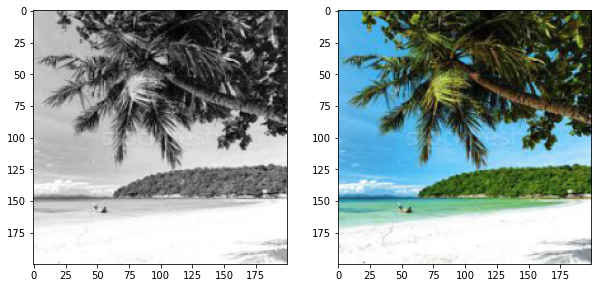

In [3]:
dim = 200
padding = 55

imgs = []

for idx, file in enumerate(filenames): 
    imgs.append(utils.Image(filenames[idx], resize=dim, padding=padding))

    
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(-imgs[0].gray_nopadding, cmap=plt.get_cmap('Greys'))
axes[1].imshow(cv2.cvtColor(imgs[0].data_nopadding, cv2.COLOR_BGR2RGB))

## Identify cluster using kmeans 

In [4]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [5]:
img = imgs[0].data_nopadding/255
n_colors = 64


w, h, d = tuple(img.data.shape)

image_array = np.reshape(img, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)

kmeans = KMeans(n_clusters=n_colors, random_state = 0, verbose=0).fit(image_array_sample)

In [6]:
clusters  = kmeans.cluster_centers_

clusters = np.array(clusters)

indeces_of_nearest_cluster = kmeans.predict(image_array)
indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))

In [7]:
new_image  = np.zeros(shape = (w,h,d))
for row in range(w):
    for col in range(h):
        new_image[row, col, 0] = clusters[indeces_of_nearest_cluster[row, col], 0]
        new_image[row, col, 1] = clusters[indeces_of_nearest_cluster[row, col], 1]
        new_image[row, col, 2] = clusters[indeces_of_nearest_cluster[row, col], 2]
        
        
new_image = (new_image*255).astype('uint8')

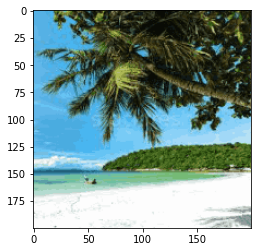

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

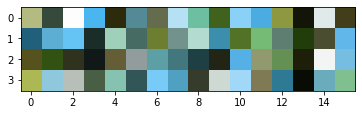

In [9]:
colors = (clusters*255).reshape(4, -1, 3).astype('uint8')
plt.imshow(cv2.cvtColor(colors, cv2.COLOR_BGR2RGB))

## Converting RGB to one-hot encoding 
Do this for all images in `imgs` list 

In [10]:
y = [] 

for img in imgs: 

    img = img.data_nopadding/255

    w, h, d = tuple(img.data.shape)

    image_array = np.reshape(img, (w * h, d))
    
    indeces_of_nearest_cluster = kmeans.predict(image_array)
    indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))
    
    utils.get_onehotencoding_vectors(indeces_of_nearest_cluster, n_colors, y) 
       

y = np.array(y)

X, _ = utils.imgs_to_dataset(filenames, resize=dim, padding=padding, window_size=11)

In [11]:
X.shape, y.shape

((200000, 121), (200000, 64))

Test with just one image first 

In [12]:
w_size = 11
img = imgs[0]

X__, y__ = utils.img_to_dataset(img, window_size=w_size)

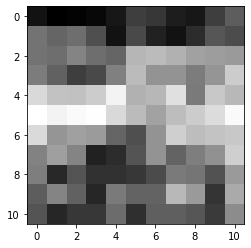

In [13]:
# Example of what a window looks like
idx = np.random.randint(len(X))
plt.imshow(X[idx].reshape(w_size, w_size), cmap=plt.get_cmap('Greys'))

In [14]:
X__.shape, y__.shape

((40000, 121), (40000, 3))

train, test split 

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2019)

In [16]:
X_train.shape, y_train.shape

((180000, 121), (180000, 64))

## Model building 

In [17]:
from tensorflow.keras.layers import Dense, InputLayer

In [21]:
model = tf.keras.Sequential([ 
    Dense(100, input_shape=(w_size**2, ), activation='relu'), 
    Dense(200, activation='relu'), 
    Dense(n_colors, activation='sigmoid')
])

opt = tf.keras.optimizers.SGD()
model.compile(optimizer=opt, loss='categorical_crossentropy')  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               12200     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                12864     
Total params: 45,264
Trainable params: 45,264
Non-trainable params: 0
_________________________________________________________________


In [22]:
y_train.shape

(180000, 64)

In [23]:
EPOCHS = 200

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    verbose=2)

Train on 180000 samples
Epoch 1/200
180000/180000 - 6s - loss: 8.0802
Epoch 2/200
180000/180000 - 5s - loss: 7.9730
Epoch 3/200
180000/180000 - 5s - loss: 7.9565
Epoch 4/200
180000/180000 - 5s - loss: 7.9565
Epoch 5/200
180000/180000 - 5s - loss: 7.9565
Epoch 6/200
180000/180000 - 5s - loss: 7.9565
Epoch 7/200
180000/180000 - 5s - loss: 7.9676
Epoch 8/200
180000/180000 - 5s - loss: 8.0225
Epoch 9/200
180000/180000 - 5s - loss: 8.0225
Epoch 10/200
180000/180000 - 5s - loss: 8.0225
Epoch 11/200


KeyboardInterrupt: 

## Test on image 

In [ ]:
img = imgs[0]
# img = utils.Image('data/cat/orange/cat05.jpg', resize=200, padding=50) 

X_test = []

for i in range(dim): 
    for j in range(dim): 

        i_ = i + img.padding
        j_ = j + img.padding

        grays, b, g, r = img.get_dataset_for_pixel(i_, j_, window_size=w_size)
        X_test.append(grays)
X_test = np.array(X_test)
        
y_model = model.predict(X_test)

In [ ]:
new_image  = np.zeros(shape = (y_model.shape[0], 3))

for i in range(y_model.shape[1]):              
    new_image[i] = clusters[np.argmax(y_model[i, :])]
        
new_image = (new_image*255).astype('uint8')
new_image = new_image.reshape(dim, dim, 3)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(img.data_nopadding, cv2.COLOR_BGR2RGB))
ax[1].imshow(-img.gray_nopadding, cmap=plt.get_cmap('Greys'))
ax[2].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))